In [27]:
pip install kmodes

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# **Customer Segmentation using clustering**

Customer segmentation is the process of dividing customers into specific groups or categories that best describe their common behaviors and interests. 

In this assignment, you will perform a customer segmentation for bank customer to identify the credit worthiness using various clustering methods.  

## **Learning Objective**

By the end of this assignment, a student will be able to:

- Perform data analysis and identify the features suitable for clustering.

- Apply different clustering methods for customer segmentation.

- Analyze the results of clustering and pick the best approach.

## **Data Descriptions**



For this assignment, we are going to use the **German Credit(Statlog) Dataset**. This data set contains data used to evaluate credit applications in Germany. It has 1000 instances with 20 categorical attributes, but in this assignment, we will use the clean version of this dataset with just `8` attributes.

**Source:** https://archive.ics.uci.edu/ml/datasets/Statlog+%28German+Credit+Data%29

**Author:** Professor Dr. Hans Hofmann

**Original Source:** Professor Dr. Hans Hofmann, Institut f"ur Statistik und "Okonometrie, Universit"at Hamburg, FB Wirtschaftswissenschaften, Von-Melle-Park 5, 2000 Hamburg 13


**Number of Instances:** 1000
**Number of Attributes:** 8

**Attribute Information:**
The detail information of each attribute:

1. Age (numeric)
2. Sex (text: male, female)
3. Job (numeric: 0 - unskilled and non-resident, 1 - unskilled and resident, 2 - skilled, 3 - highly skilled)
4. Housing (text: own, rent, or free)
5. Saving accounts (text - little, moderate, quite rich, rich)
6. Checking account (numeric, in DM - Deutsch Mark)
7. Credit amount (numeric, in DM)
8. Duration (numeric, in a month)
9. Purpose (text: car, furniture/equipment, radio/TV, domestic appliances, repairs, education, business, vacation/others)


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

In [2]:
warnings.filterwarnings("ignore")
sns.set_style('whitegrid')
sns.set_palette('rainbow')

plt.rcParams['figure.figsize'] = (10, 5)

In [3]:


df = pd.read_csv('https://storage.googleapis.com/codehub-data/1-lv2-A-9-bank_credit.csv')
df.head()

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose
0,67,male,2,own,NaN,little,1169,6,radio/TV
1,22,female,2,own,little,moderate,5951,48,radio/TV
2,49,male,1,own,little,NaN,2096,12,education
3,45,male,2,free,little,little,7882,42,furniture/equipment
4,53,male,2,free,little,little,4870,24,car


## Data Informations

In the following few sections, we will visualize our data and try to get some insight into the dataset. We will see if the given attributes/features in the dataset can help in customer segmentation or not and see which clustering methods help to best segment the customers.

First off, let's look at the dataset information.

In [4]:
## Run this cell

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Age               1000 non-null   int64 
 1   Sex               1000 non-null   object
 2   Job               1000 non-null   int64 
 3   Housing           1000 non-null   object
 4   Saving accounts   817 non-null    object
 5   Checking account  606 non-null    object
 6   Credit amount     1000 non-null   int64 
 7   Duration          1000 non-null   int64 
 8   Purpose           1000 non-null   object
dtypes: int64(4), object(5)
memory usage: 70.4+ KB


Our dataset has `9` features with `4` numerical, `5` categorical features, and `1000` instances. `Job` is a number encoded categorical feature, so in total, we have only `3` numerical features. Our `Saving accounts` and `Checking account` have some missing values. We will do some data analysis and check for the feature importance; if these features are essential, we will perform necessary measures for missing value imputation.

Now, since KMeans and other clustering algorithms works with numerical features, we will first segment our customers using our available numerical attributes like customer's Age, Credit amount and Duration. Later, we will use variant of KMeans for mixed features.


## **Exercise 1: Data pre-processing**  

**[Points: 2]**

In this exercise, you will perform some data pre-processing to fit it in a clustering model.

**Task:**


1. Check for the data skewness and outliers then use appropriate transformation to fix the skewness and de-emphasizes outliers from the data (Decide the transformation method on your own).
2. Use `sklearn`'s standard scaler to scale the data.

In [5]:
## Select columns for clustering

selected_cols = ["Age","Credit amount", "Duration"] # using numerical features only
cluster_data = df.loc[:, selected_cols]

In [6]:
from mpl_toolkits.mplot3d import Axes3D 

def _3d_data_plot(data, labels=None):
    """Wrapper for 3D data plot
    
    Parameters:
        data: pandas dataframe
        labels: labels of the data points(if available)
        
    """
    fig = plt.figure(figsize=(15,10))
    ax = fig.add_subplot(111, projection='3d')

    g = ax.scatter(data["Credit amount"], data["Duration"], data["Age"], c=labels if labels is not None else 'black', cmap='rainbow')
    ax.set_xlabel("Credit amount")
    ax.set_ylabel("Duration")
    ax.set_zlabel("Age")
    plt.tight_layout()
    

def scatter_plot(data, hue=None):
    """Wrapper for seaborn scatter plot.
    
    Parameters:
        data: pandas dataframe
        hue: variable to distinguish data w.r.t(optional)
        palette: color palette(optional)
        
    """
    fig, (ax1, ax2, ax3) = plt.subplots(3,1, figsize=(8,8))
    
    sns.scatterplot(x="Credit amount",y="Duration", hue=hue, data=data, ax=ax1, palette='rainbow')
    sns.scatterplot(x="Age",y="Credit amount", hue=hue, data=data, ax=ax2, palette='rainbow')
    sns.scatterplot(x="Age",y="Duration", hue=hue, data=data, ax=ax3, palette='rainbow')
    
    plt.tight_layout()
    
def box_plot(df):
    """Wrapper for box ploting
    
    Parameters:
        df: pandas dataframe
    """

    fig, ax = plt.subplots(1,3,figsize=(20,5))
    sns.boxplot(df['Credit amount'], ax=ax[0])
    sns.boxplot(df['Duration'], ax=ax[1])
    sns.boxplot(df['Age'], ax=ax[2])
    plt.tight_layout()
    
def distributions_plot(df):
    """Wrapper for ploting data distributions
    
    Parameters:
        df: pandas dataframe
    """
    fig, ax = plt.subplots(1, 3, figsize=(20,5))
    sns.distplot(df["Age"], ax=ax[0])
    sns.distplot(df["Credit amount"], ax=ax[1])
    sns.distplot(df["Duration"], ax=ax[2])
    plt.tight_layout()
    


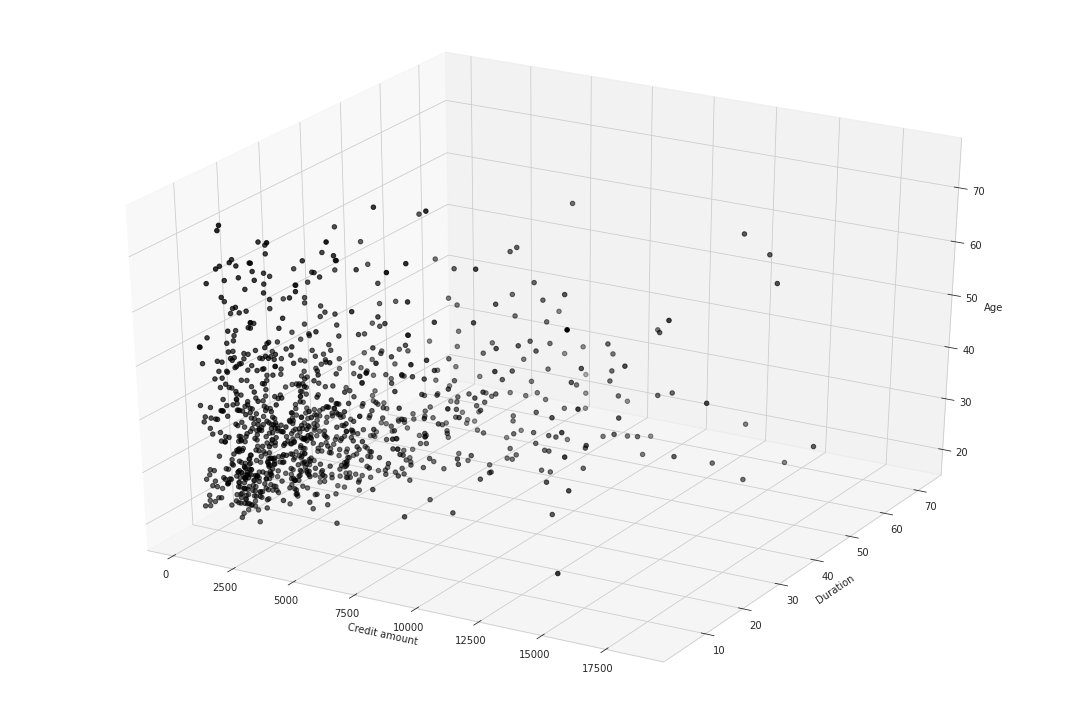

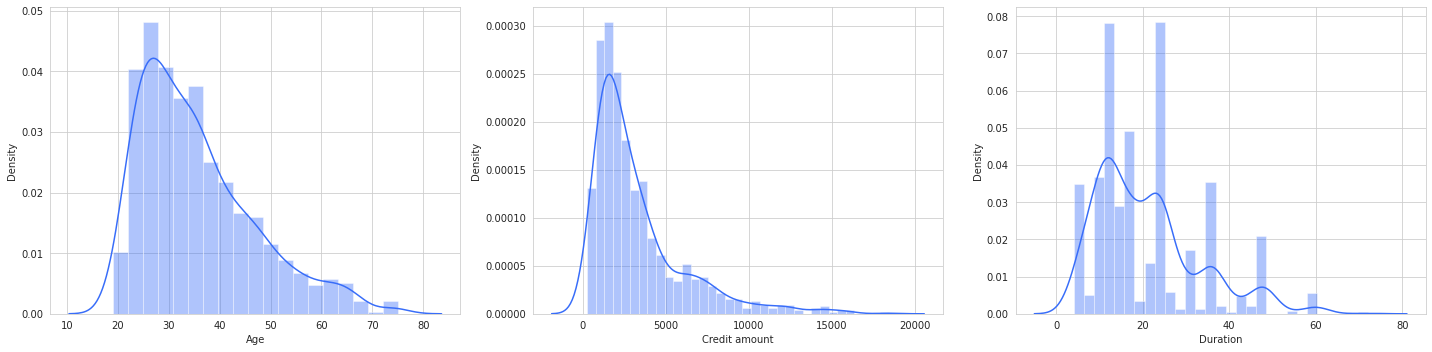

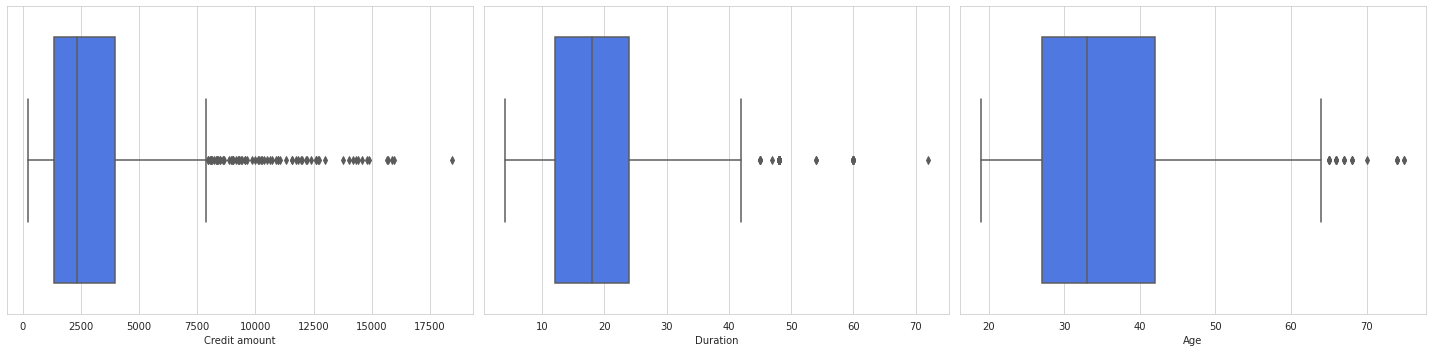

In [7]:
## Plots
_3d_data_plot(cluster_data)
distributions_plot(cluster_data)
box_plot(cluster_data)

From the distribution plot we can see that given features are right skewed and from the box plots we can identify that data has outliers.

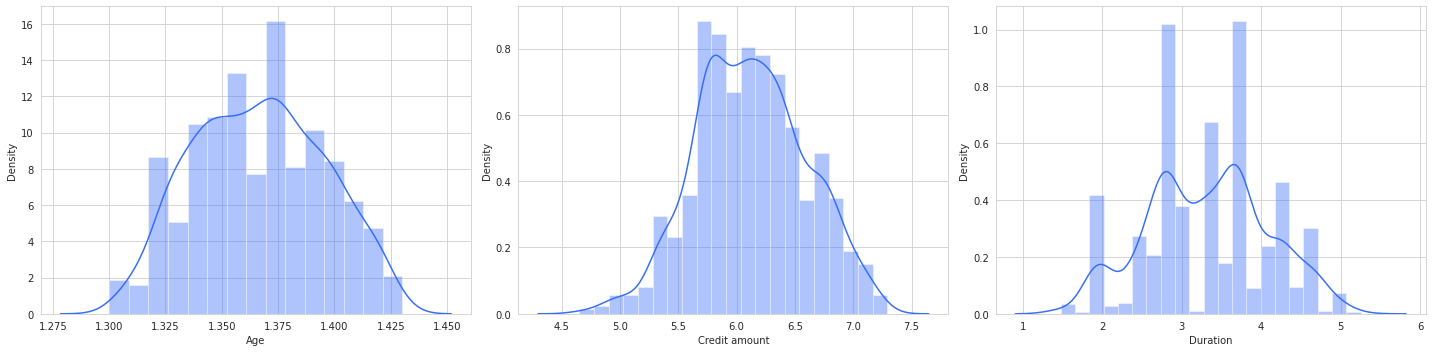

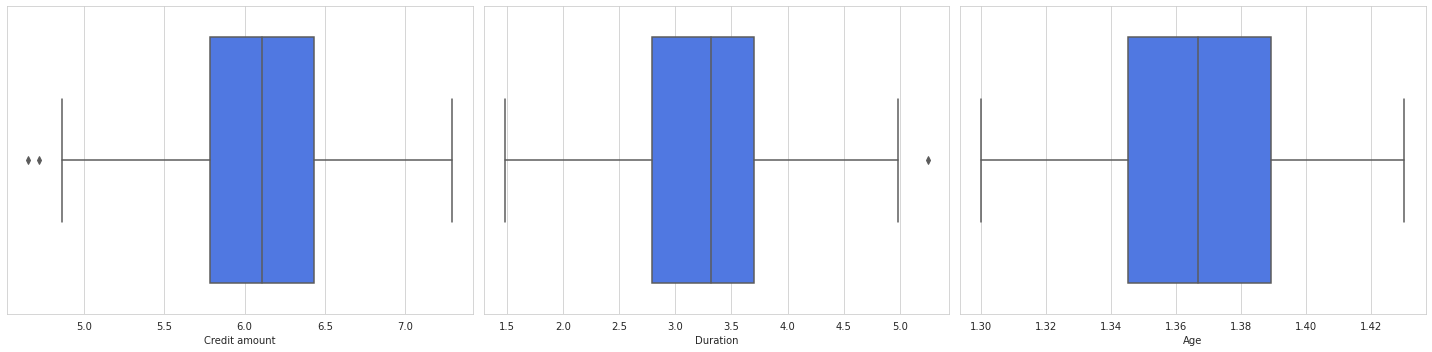

In [8]:
### Ex-1-Task-1
skew_fix_data = None

## Your code here ~ 1-4 lines

### BEGIN SOLUTION
# your code here
from scipy.stats import boxcox
skew_fix_data = pd.DataFrame()

for col in selected_cols:
    skew_fix_data[col], _ = boxcox(cluster_data[col])
# raise NotImplementedError
### END SOLUTION

distributions_plot(skew_fix_data)
box_plot(skew_fix_data)

In [9]:
assert skew_fix_data is not None, 'Invalid data'

Now that data we fixed the skewnees in data, let's scale our data using `sklearn`.

In [10]:
### Ex-1-Task-2
scaler = None
scaled_data = None

## Your code here ~ 3 lines

### BEGIN SOLUTION
# your code here
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_data = scaler.fit_transform(skew_fix_data)
# raise NotImplementedError
### END SOLUTION

In [11]:
scaled_data.mean(), scaled_data.var()

(-5.459336686423437e-16, 1.0)

In [12]:
assert scaled_data is not None


## **Exercise 2: _K_-Means Clustering** 

In this exercise, you will build a `KMeans` algorithm using `sklearn` and loop over a certain cluster range of cluster values to find the best `k` clusters.

**[Points: 3]**



**Task:**


1. From the certain cluster range, get the `inertia_` value from `KMeans` model for the elbow method.
2. Get the silhouette score from `KMeans` with different random sampling.
3. Analyze the `KMeans` results and pick the appropriate `n_clusters` value then build the final model.

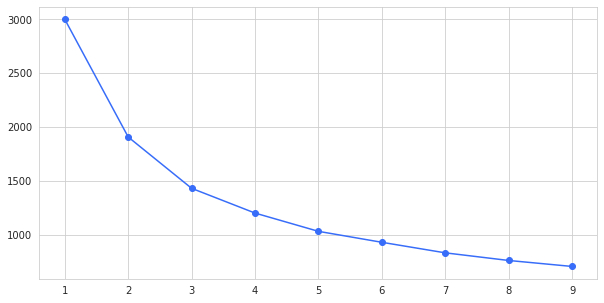

In [13]:
### Ex-2-Task-1
clusters_range = None
inertias = []
kmeans = None

## Your code here ~ 3-5 lines

### BEGIN SOLUTION
# your code here
from sklearn.cluster import KMeans
clusters_range = range(1,10)
inertias = []
for k in clusters_range:
  kmeans = KMeans(n_clusters=k) 
  kmeans.fit(scaled_data)
  inertias.append(kmeans.inertia_)
# raise NotImplementedError
### END SOLUTION

plt.plot(clusters_range, inertias, marker='o')
plt.show()

From the plot above, can you find the optimal number of clusters?

If you can pick the optimal number of clusters, then use it to build a final model, but let's explore another alternative method for choosing optimal cluster value.

Below you will generate ranges for `n_clusters` values and `random_state ` and try `KMeans` model on the different seed values with different `n_clusters`. This approach helps get the optimal cluster number where the silhouette values are stable with different `random_state` values.

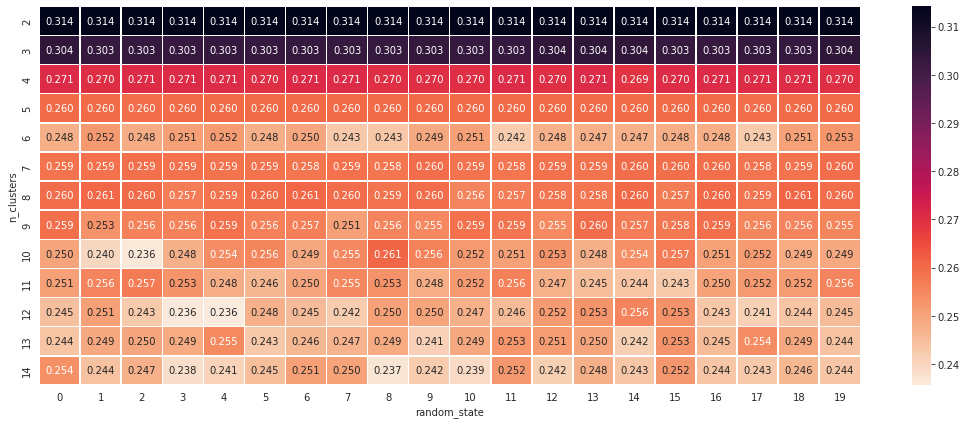

In [14]:
### Ex-2-Task-2
from sklearn.metrics import silhouette_score

clusters_range = None # range of cluster values
random_range = None # range for random state
results = [] # results list with n_clusters, random_state and silhoette score

## Your code here ~ 4-8 lines

### BEGIN SOLUTION
# your code here
clusters_range = range(2, 15)
random_range = range(0, 20)
for c in clusters_range:
    for r in random_range:
        cluster_model = KMeans(n_clusters=c, random_state=r)
        cluster_labels = cluster_model.fit_predict(scaled_data)
        avg_silhouette = silhouette_score(scaled_data, cluster_labels)
        results.append([c, r, avg_silhouette])
# raise NotImplementedError
### END SOLUTION

## Create table
result = pd.DataFrame(results, columns=["n_clusters","random_state","silhouette_score"])
pivot_km = pd.pivot_table(result, index="n_clusters", columns="random_state", values="silhouette_score")

## Plot table
plt.figure(figsize=(15,6))
sns.heatmap(pivot_km, annot=True, linewidths=.5, fmt='.3f', cmap=sns.cm.rocket_r)
plt.tight_layout()

Now, by analyzing the table above, pick the optimal `random_state` and `n_clusters` value (Pick the one with stable values) and build your final `KMeans` model.

In [15]:
### Ex-2-Task-3
final_kmeans = None
labels = None

## Your code here ~ 2 lines

### BEGIN SOLUTION
# your code here
final_kmeans = KMeans(n_clusters=3, random_state=1).fit(scaled_data)
labels = pd.DataFrame(final_kmeans.labels_)
# raise NotImplementedError
### END SOLUTION

clustered_data = cluster_data.assign(Cluster=labels)

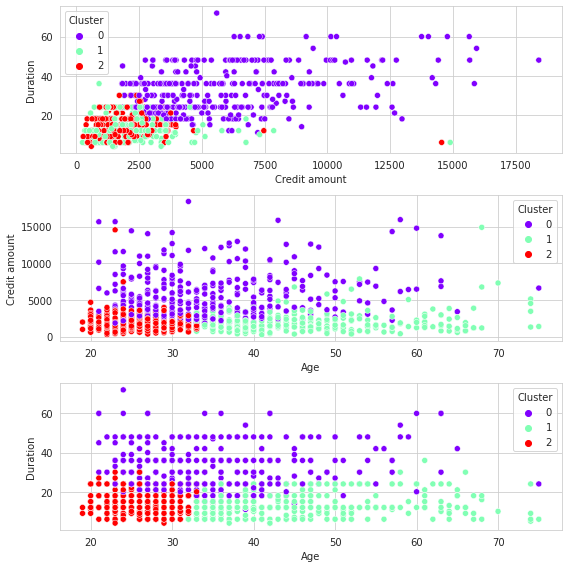

In [16]:
## Plot clustered data
scatter_plot(clustered_data, 'Cluster')

### KMeans Results

In [17]:
grouped_km = clustered_data.groupby(['Cluster']).mean().round(1)
grouped_km

,Age,Credit amount,Duration
Cluster,,,
0,34.7,5691.1,32.3
1,45.7,1917.3,13.6
2,26.1,1779.9,14.8


The above dataframe shows the age of the customer with an average credit amount and the average duration.

Let's visualize the clusters in 3D for our 3-dimensional features.

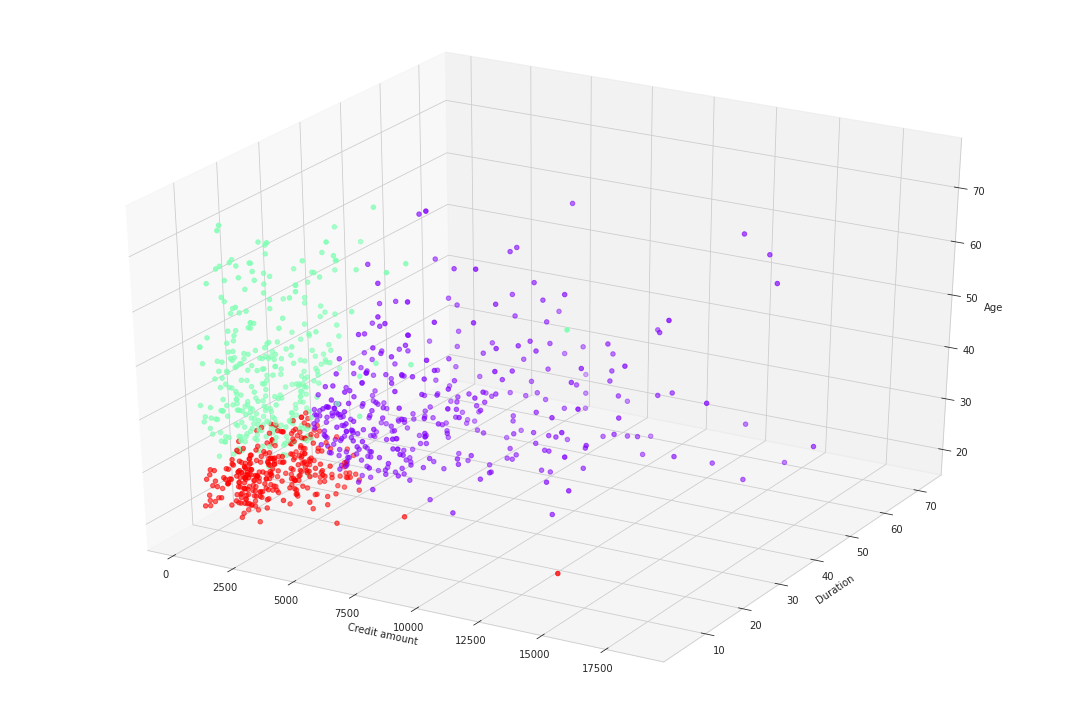

In [18]:
_3d_data_plot(clustered_data, labels=final_kmeans.labels_)

## **Exercise 3: Hierarchical clustering**  

**[Points: 3]**

Now that you have seen how `KMeans` clusters the data, let's look at the implementation of hierarchical clustering methods and analyze if it does better than `KMeans` or not. 

In this exercise, you will build a hierarchical clustering model and analyze the results.

**Task:**


1. Build a linkage using `scipy` for our data with `method` of your own knowledge.

2. Build a dendrogram to identify the number of clusters.

3. Build `AgglomerativeClustering` model from scratch with the best `n_cluster` value.



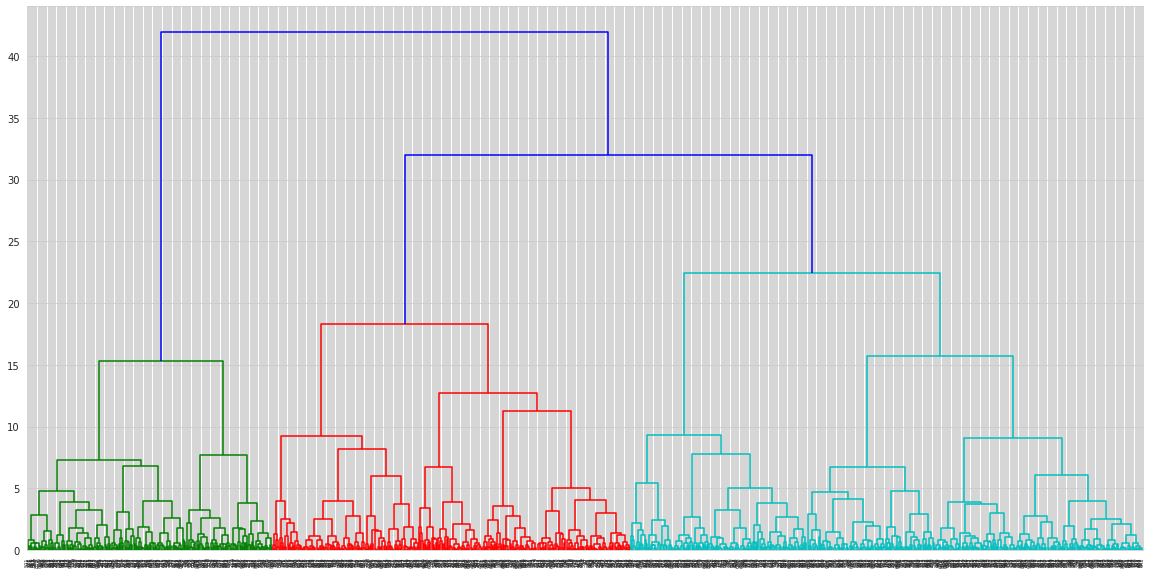

In [19]:
### Ex-3-Task-1
plt.figure(figsize=(20, 10))

linkage_method = None

### BEGIN SOLUTION
# your code here
from scipy.cluster.hierarchy import dendrogram, linkage
linkage_method = 'ward'
linkage = linkage(scaled_data, method=linkage_method)
dendogram_plot = dendrogram(linkage)
# raise NotImplementedError
### END SOLUTION

In [20]:
### Ex-3-Task-2
hac_model = None
hac_labels = None

### BEGIN SOLUTION
# your code here
from sklearn.cluster import AgglomerativeClustering
hac_model = AgglomerativeClustering(n_clusters=3, linkage=linkage_method)
hac_model.fit(scaled_data)
hac_labels = hac_model.labels_
# raise NotImplementedError
### END SOLUTION

In [21]:
assert hac_model is not None
assert hac_labels is not None

          Age  Credit amount  Duration
Cluster                               
0        28.7         2237.4      18.7
1        35.4         7306.2      36.7
2        45.3         1984.1      13.2


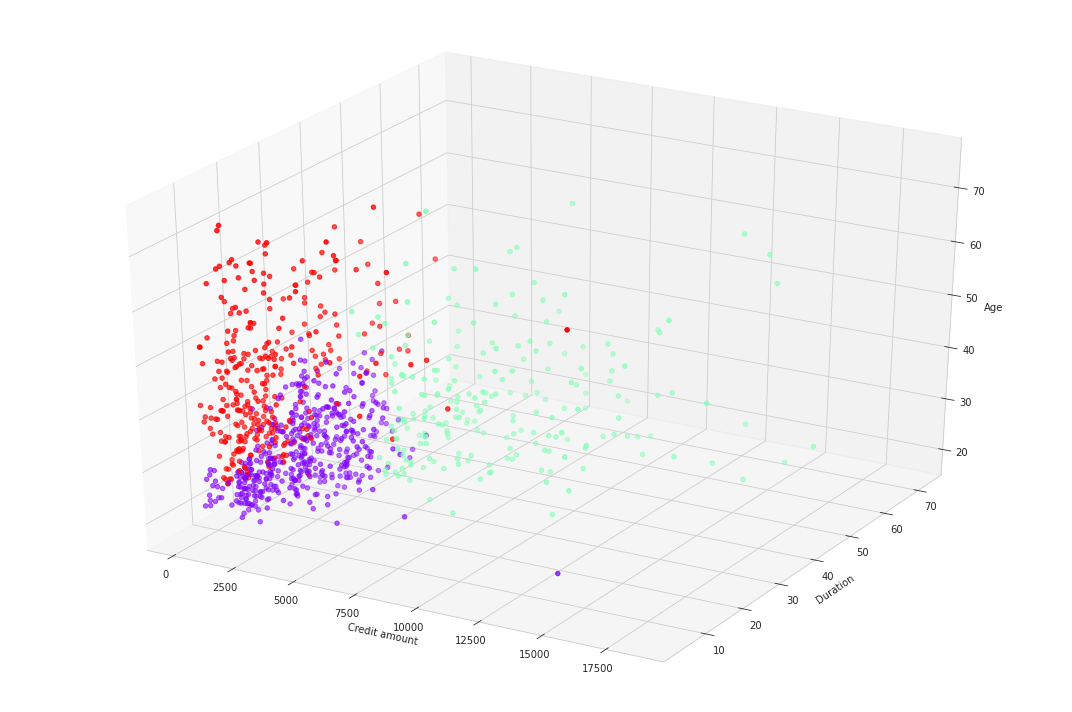

In [22]:
df_clustered_hac = cluster_data.assign(Cluster=hac_labels)
grouped_hac = df_clustered_hac.groupby(['Cluster']).mean().round(1)
print(grouped_hac)
_3d_data_plot(cluster_data, labels=hac_labels)

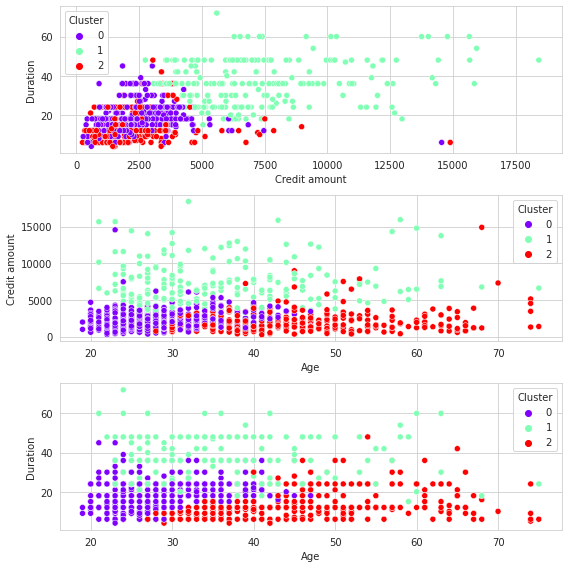

In [23]:
scatter_plot(df_clustered_hac, 'Cluster')


## **Exercise 4: _K_-Prototypes for mixed features** 

In this exercise, you will build a variant of `KMeans` algorithm to cluster the mixed features.

**[Points: 2]**



**Task:**


1. Fill the missing values identified earlier with appropriate imputation method.
2. Use `_K_-Prototypes` algorithm to prepare clusters from all the available features (numerical + categorical)
3. Pass column index of categorical features as a list to an algorithm to identify the categorical features

**Note:** `KPrototypes` has a same pipelie as `sklearn`'s other algorithms

In [28]:
### Ex-4-Task-1
from kmodes.kprototypes import KPrototypes

kp_labels = None
categorical_indexes = []

### BEGIN SOLUTION
# your code here
df['Checking account'].fillna(df['Checking account'].mode()[0], inplace=True)
df['Saving accounts'].fillna(df['Saving accounts'].mode()[0], inplace=True)

categorical_indexes = [1, 2, 3, 4, 5, 8]
kp_labels = KPrototypes(n_clusters=3).fit_predict(df.values, categorical=categorical_indexes)
# raise NotImplementedError
### END SOLUTION

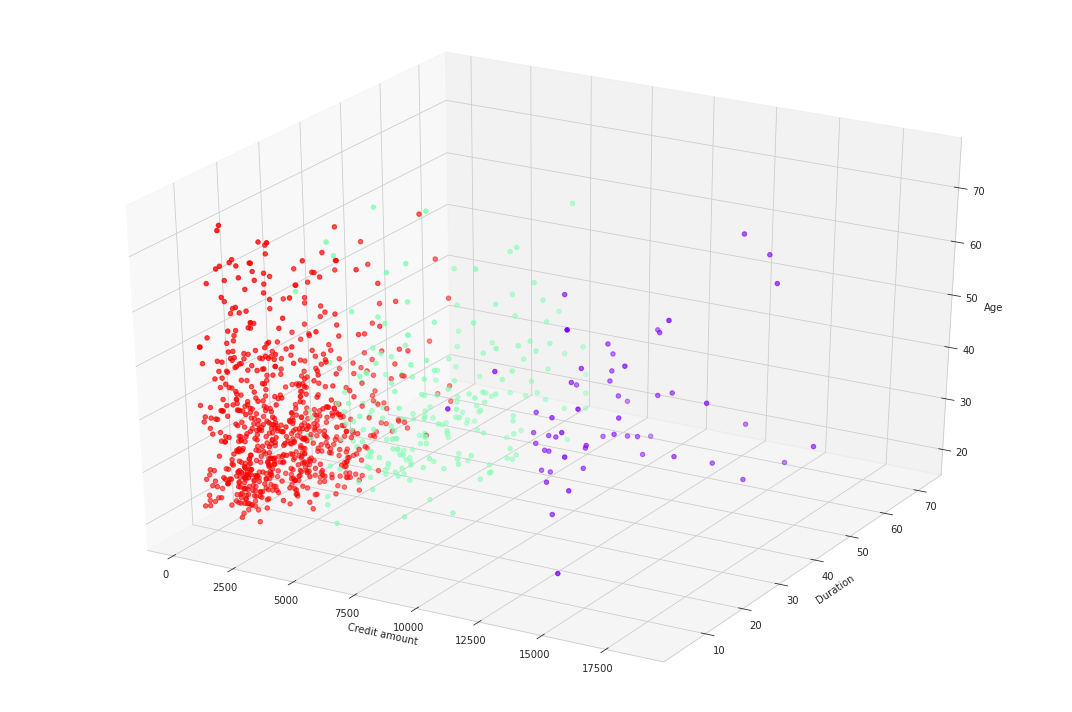

In [29]:
kp_assigned = df.assign(Cluster=kp_labels)
_3d_data_plot(df, kp_labels)

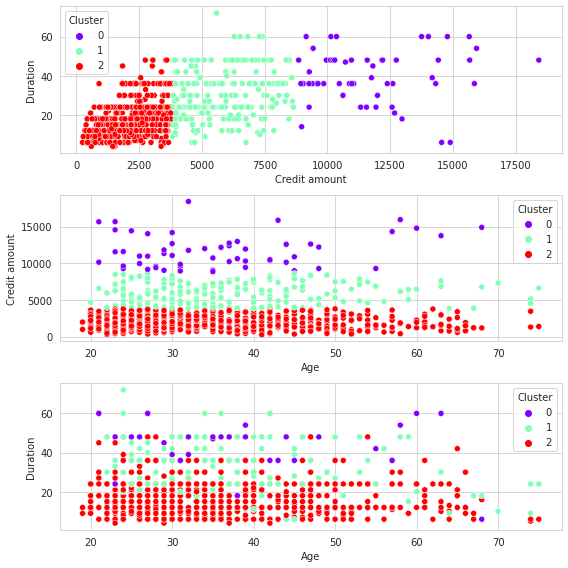

In [30]:
scatter_plot(kp_assigned, 'Cluster')

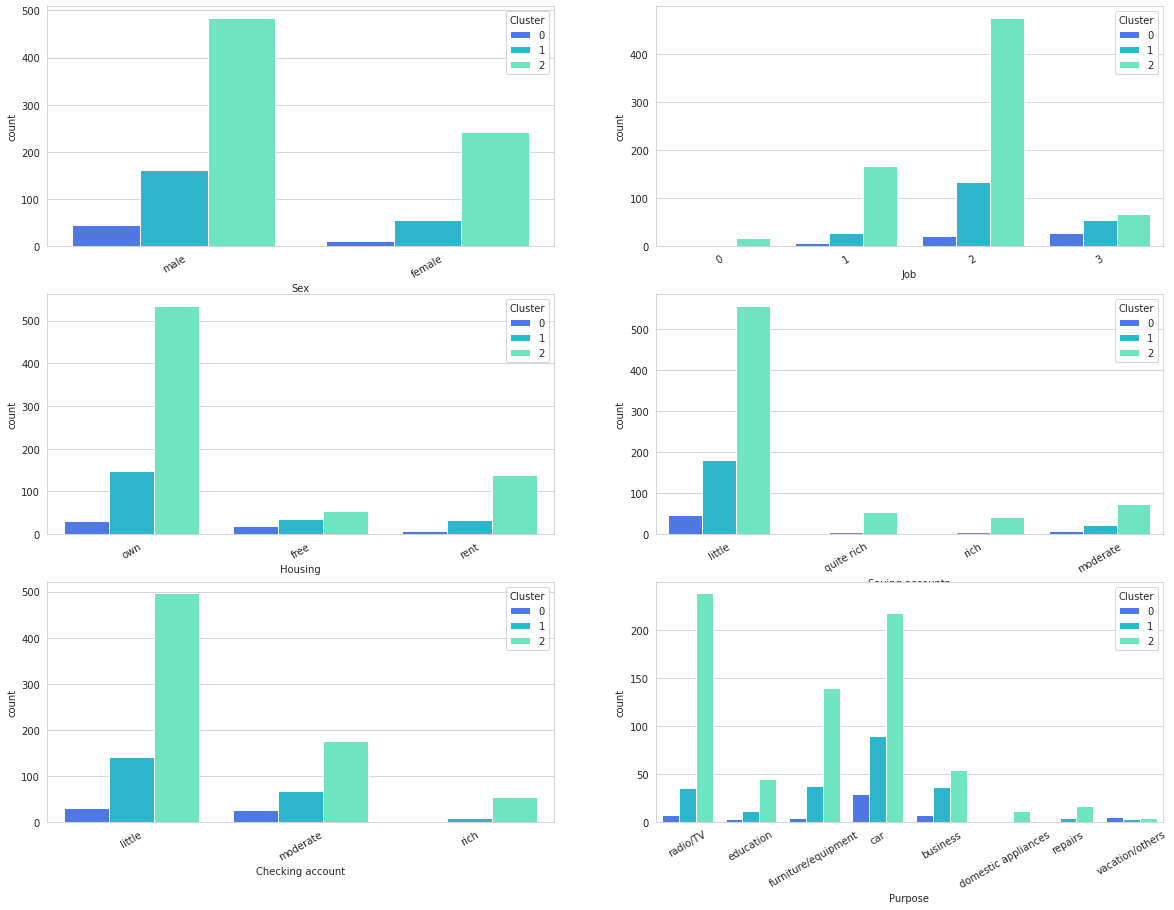

In [31]:
fig = plt.figure(figsize = (20,15))
axes = 320
for cat in df.columns[categorical_indexes]:
    axes += 1
    fig.add_subplot(axes)
    sns.countplot(data = kp_assigned, hue=kp_assigned['Cluster'], x = cat)
    plt.xticks(rotation=30)
plt.show()

<center>
    <b>THE END</b>
</center>